# Bilan Carbone Datarmor

## Recuperations heures CPU

Denis a envoye un mail contenant les heures CPU pour les utilisateur affilies a Marbec (groupes unix `emeX`, `marbecmd`). Ce mail a ete traite pour mettre les donnees au format CSV. 

Ensuite, le temps CPU mensuel par utilisateur a ete trace:

In [1]:
import numpy as np
import pandas as pd
import re

months = ['janvier', 'fevrier', 'mars', 'avril', 'mai', 'juin', 'juillet', 'aout', 'septembre', 'octobre', 'novembre', 'decembre']
years = list(np.arange(2017, 2021 + 1))
nyears = len(years)
nmonths = len(months)

users = [
'adupaix',
'aduparc',
'amorell',
'aroy',
'bcheikhm',
'cfelix',
'clujanpa',
'dkaplan',
'echassot',
'fbriton',
'fleloch',
'fmoullec',
'gperez',
'iperez',
'jbarde',
'jlebranc',
'jrault',
'lescalle',
'mandrell',
'mbelhare',
'mcapello',
'mlengaig',
'mmetge',
'msimier',
'msoria',
'nbarrier',
'nbez',
'omaury',
'rioliver',
'sakia',
'sdrira',
'timzilen',
'vdaniell',
'vdupre',
'yjshin',
'yyhamemo',
'cdelord',
'fhoungna',
'ipitavac']

nusers = len(users)

regexp = re.compile('^[0-9].*')

output = np.zeros((nyears, nmonths, nusers))

with open('data-datarmor/mail_denis.txt') as f:
    lines = f.readlines()

for l in lines:
    
    l = l.strip()
    if(regexp.match(l)):
        y, m = l.split(' ')
        imonth = months.index(m)
        iyear = years.index(int(y))
    else:
        l = re.sub(' +', ' ', l)
        user, cpu = l.split(' ')
        iuser = users.index(user)

        output[iyear, imonth, iuser] = float(cpu)

months = np.arange(12) + 1

output = np.reshape(output, (nyears * nmonths, nusers))
months, years = np.meshgrid(months, years)
months = np.ravel(months)
years = np.ravel(years)
date = months + years * 1000

data = {}
data['years'] = years
data['months'] = months
for i in range(nusers):
    u = users[i]
    data[u] = output[:, i]

dsout = pd.DataFrame(data)

# Removing users with 0 conso
columns = dsout.columns
total = dsout.sum(axis=0)
iok = np.nonzero(total.values == 0)[0]
dsout = dsout.drop(columns = columns[iok])
columns = dsout.columns
dsout.to_csv('formatted_cpu.csv')

print(dsout.tail())

    years  months  amorell  bcheikhm  cfelix  clujanpa  dkaplan  fbriton  \
55   2021       8      0.0       0.0     0.0       0.0      0.0      0.0   
56   2021       9      0.0       0.0     0.0       0.0      0.0      0.0   
57   2021      10      0.0       0.0     0.0       0.0      0.0      0.0   
58   2021      11      0.0       0.0     0.0       0.0      0.0      0.0   
59   2021      12      0.0       0.0     0.0       0.0      0.0      0.0   

    fmoullec  gperez  ...  nbarrier  omaury  sakia  sdrira  timzilen  vdupre  \
55       0.0     0.0  ...       0.0     0.0    0.0     0.0       0.0     0.0   
56       0.0     0.0  ...       0.0     0.0    0.0     0.0       0.0     0.0   
57       0.0     0.0  ...       0.0     0.0    0.0     0.0       0.0     0.0   
58       0.0     0.0  ...       0.0     0.0    0.0     0.0       0.0     0.0   
59       0.0     0.0  ...       0.0     0.0    0.0     0.0       0.0     0.0   

    yjshin  yyhamemo  fhoungna  ipitavac  
55     0.0       0.

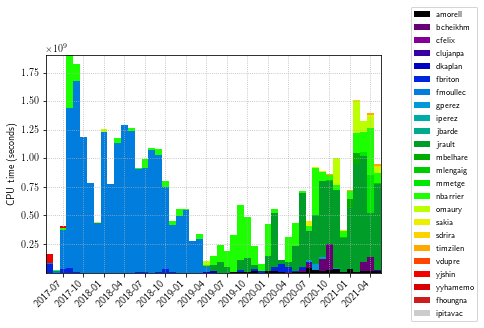

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = pd.read_csv('formatted_cpu.csv', index_col=0)

years = data.loc[:, 'years'].values
months = data.loc[:, 'months'].values

data = data.iloc[:, 2:]
users = list(data.columns)
nusers = len(users)

nlines, ncol = data.shape

colors = plt.cm.nipy_spectral

fig = plt.figure()
ax = plt.gca()

width = 1

lobj = []

for i in range(nlines):

    bottom = 0
    for u in range(nusers):
        ic = u / (nusers - 1)
        temp = data.iloc[i, u]
        b = ax.bar(i, temp, width=width, bottom=bottom, color=colors(ic))
        if(i == 0):
            lobj.append(b)
        bottom += temp

temp = np.sum(data.values, axis=1)
iok = np.nonzero(temp !=0)[0]

xticks = np.arange(nlines)
xticklabels = ['%.4d-%.2d' %(y, m) for y, m in zip(years, months)]

stride = 3

ax.set_xticks(xticks[::stride])
ax.set_xticklabels(xticklabels[::stride], rotation=45, ha='right')
plt.grid(True)

ax.set_xlim(iok[0] - 0.5, iok[-1] + 0.5)
ax.set_ylabel('CPU time (seconds)')

plt.legend(lobj, users, fontsize=8, ncol=1, loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

## Estimation consomation d'un coeur

La consomation d'une heure CPU a ete estimee a partir du rapport `Datarmor_Exploitation_Rapport_2020-T3.pdf` fourni par Denis.

Ainsi, on a:

In [3]:
# Puissance totale
# Ici, on a une puissance, donc c'est un flux. Si on prend le premier mois par exemple, on a une puissance de 165.34 kW# Donc en 1h, Datarmor consomme 165.34 kWh.# Donc la conso total de Datarmor sur ce mois est 165.34 * nb d'heures dans le mois ?ptot = 165.34 + 157.75 + 161.18  # kW
# Heures CPU totales
cputot = (5202 + 4009 + 4817) * 1000  # conversion kiloheure/heure

mean = ptot / cputot # conversion from kW
print('Puissance moyenne heure CPU (kW): ', mean)

Puissance moyenne heure CPU (kW):  3.452167094382664e-05


## Estimation consomation totale

Pour avoir la consomation totale, on somme sur tous les utilisateurs les temps CPU, que l'on multiplie par la consomation moyenne d'un noeud:

In [4]:
import pandas as pd
import numpy as np

data = pd.read_csv('formatted_cpu.csv')
data['years'] = data['years'].astype('category')

# conversion from seconds to hours
conv = 1 / (60 * 60)

# Sum over years
data = data.groupby('years').sum()

# Sum over users
print('Consomation totale (kWh)')
data = data.sum(axis=1) * mean * conv
print(data)


Consomation totale (kWh)
years
2017     64.646096
2018    111.713692
2019     34.220772
2020     67.544942
2021     56.637165
dtype: float64


## Consomation de carbone

Pour convertir la consomation en equivalent CO2, on considere qu'en France, 1 kWh est equivalent a 0.1 kg d'equivalent CO2. Ainsi, les emissions sont obtenues en multipliant le tableu precedent par 0.1

In [5]:
conv = 0.1
kg2ton = 1e-3

print('Equivalent CO2 (ton eq. CO2)')
print(data * conv * kg2ton)

Equivalent CO2 (ton eq. CO2)
years
2017    0.006465
2018    0.011171
2019    0.003422
2020    0.006754
2021    0.005664
dtype: float64
